In [10]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
N = 100
L = 1000
T = 20

In [3]:
x = np.empty((N,L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)

In [4]:
y = np.sin(x/1.0/T).astype(np.float32)

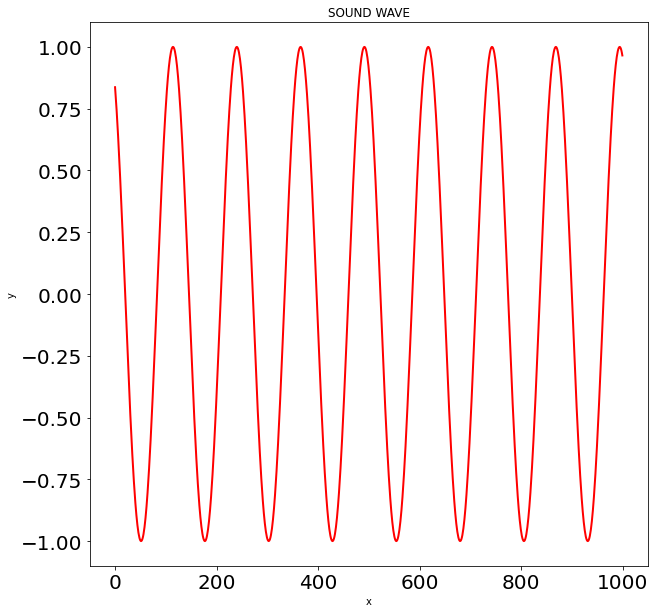

In [9]:
plt.figure(figsize=(10,10))
plt.title("SOUND WAVE")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:], "r", linewidth=2.0)
plt.show()

In [13]:
class LSTMPredictor(nn.Module):
  def __init__(self,n_hidden=51):
    super(LSTMPredictor,self).__init__()
    self.n_hidden = n_hidden
    #lstm1, lstm2, linear
    self.lstm1 = nn.LSTMCell(1,self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden,1)

  def forward(self, x, future=0): #You can set future 1000 if u want to predict next 1000 values
    outputs = []
    n_samples = x.size(0)

    h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

    for input_t in x.split(1, dim=1): # this will splut our tensor into 1 value chunk (If our tensor was N,100 size -> here we will get N,1)
      h_t,c_t = self.lstm1(input_t, (h_t,c_t))
      h_t2,c_t2 = self.lstm2(h_t, (h_t2,c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    for i in range(future):
      h_t,c_t = self.lstm1(output, (h_t,c_t))
      h_t2,c_t2 = self.lstm2(h_t, (h_t2,c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    outputs = torch.cat(outputs, dim=1)
    return outputs

In [14]:
if __name__=="__main__":
  #y = 100, 1000
  train_input = torch.from_numpy(y[3:,:-1]) #97, 999
  train_target = torch.from_numpy(y[3:, 1:]) #97, 999

  test_input = torch.from_numpy(y[:3,:-1]) #3,999
  test_target = torch.from_numpy(y[:3, 1:]) #3,999

  model = LSTMPredictor()
  criterion = nn.MSELoss()

  optimizer = optim.LBFGS(model.parameters(), lr=0.8) # this optimizer works on whole data

  n_steps = 10

  for i in range(n_steps):
    print("Step ", i)

    def closure():
      optimizer.zero_grad()
      out = model(train_input)
      loss = criterion(out, train_target)
      print("Loss: ", loss.item())
      loss.backward()
      return loss
    
    optimizer.step(closure)

    with torch.no_grad():
      future = 1000
      pred = model(test_input, future=future)
      loss = criterion(pred[:, :-future], test_target)
      print("test_loss: ", loss.item())

      y = pred.detach().numpy()
    
    plt.figure(figsize=(12,12))
    plt.title(f"STEP {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    n = train_input.shape[1]
    def draw(y_i, color):
      plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
      plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')

    plt.savefig("predict%d.pdf"%i)
    plt.close()

Step  0
Loss:  0.492910772562027
Loss:  0.4897304177284241
Loss:  0.4008290767669678
Loss:  0.3587319254875183
Loss:  0.18787355720996857
Loss:  0.19491323828697205
Loss:  0.03174490109086037
Loss:  0.0308369267731905
Loss:  0.02977868542075157
Loss:  0.028539715334773064
Loss:  0.02576497569680214
Loss:  0.021511584520339966
Loss:  0.015085968188941479
Loss:  0.01011266652494669
Loss:  0.008660517632961273
Loss:  0.00603314908221364
Loss:  0.005611381493508816
Loss:  0.0028627426363527775
Loss:  0.0023949400056153536
Loss:  0.005710901226848364
test_loss:  0.0014312713174149394
Step  1
Loss:  0.0013311232905834913
Loss:  0.0011174848768860102
Loss:  0.00107076414860785
Loss:  0.0009978272719308734
Loss:  0.0009220886277034879
Loss:  0.0007590219029225409
Loss:  0.000546125287655741
Loss:  0.0005091606290079653
Loss:  0.0004972878959961236
Loss:  0.0004739828291349113
Loss:  0.0004262142756488174
Loss:  0.000356152217136696
Loss:  0.00026574693038128316
Loss:  0.00021245521202217788
Lo